#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 3 - Deep Reinforcement Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving reinforcement learning problems. The basic tasks for the homework will require to implement some extensions to the code that you have seen in the Lab. More advanced tasks will require to train and test your learning agent on a different environment. Given the higher computational complexity of RL, in this homework you don’t need to tune learning hyperparameters using search procedures and cross-validation; however, you are encouraged to play with model hyperparameters in order to find a satisfactory configuration.


## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.

As an example of more advanced libraries that can be used to implement deep RL agents, you can check this website:

https://stable-baselines.readthedocs.io/en/master/



## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). Given the dynamical nature of RL problems, you can explore more sophisticated media for showing the results of your model (e.g., animated GIFs or short movies).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	3 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym environment you like from the available list, or even explore other simulation platforms:
https://gym.openai.com/envs 

#### MoonLander

see here for the code: https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py



## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

In [1]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState


from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

In [2]:
#enable virtual rendering
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [5]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
    mp4list = glob.glob('video/*.mp4')
    mp4list.sort()
    for mp4 in mp4list:
        print(f"\nSHOWING VIDEO {mp4}")
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, folder, video_callable=None):
    env = Monitor(env, './'+folder+'_video', force=True, video_callable=video_callable)
    return env

"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

Source: https://www.nature.com/articles/nature14236

In practice, what we need is a queue with a predefined capacity. When we reach the maximum capacity, the oldest element in the queue will be replaced with the new one.

This exact behavior is implemented by the `deque` object from the python `collections` library (https://docs.python.org/3/library/collections.html#collections.deque):

"*If maxlen is not specified or is None, deques may grow to an arbitrary length. Otherwise, the deque is bounded to the specified maximum length. Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end.*"

The random sampling can be easily achieved using the `random.sample` method (https://docs.python.org/3/library/random.html).

In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 64 neurons each). 

Be sure to keep a linear output activation.

## Network definition

In [7]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 256),
                nn.Tanh(),
                nn.Linear(256, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [8]:
# Define an example network
net = DQN(state_space_dim=8, action_space_dim=4)
net

DQN(
  (linear): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)

## Exploration Policy

Starting from the estimated Q-values, we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy

With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [9]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.


In [10]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

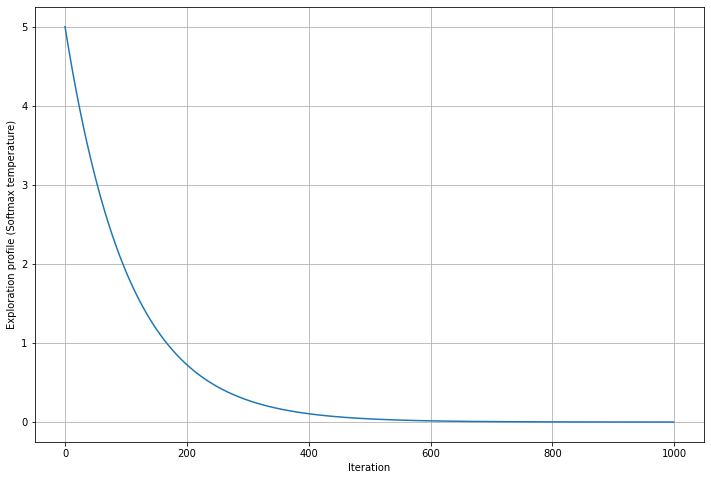

In [11]:
### Define exploration profile
initial_value = 5
#num_iterations = 1000
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

### LunarLander-v2 environment

According to Pontryagin's maximum principle it's optimal to fire engine full throttle or
turn it off. That's the reason this environment is OK to have discrete actions (engine *on* or *off*).
The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector.
Reward for moving from the top of the screen to the landing pad and zero speed is about 100..140 points.
If the lander moves away from the landing pad it loses reward. The episode finishes if the lander crashes or
comes to rest, receiving an additional -100 or +100 points. Each leg with ground contact is +10 points.
Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame.
Solved is 200 points.

Landing outside the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land
on its first attempt.

In [13]:
### Create environment
env = gym.make('LunarLander-v2')  # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)
env.reset()

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 8
ACTION SPACE SIZE: 4


The **observation space** is illustrated by a "Box" containing 8 values between [ $-\infty$, $\infty$ ] these values are::
+ Position X
+ Position Y
+ Velocity X
+ Velocity Y
+ Angle
+ Angular Velocity
+ Is left leg touching the ground: 0 OR 1
+ Is right leg touching the ground: 0 OR 1

In [14]:
env.observation_space

Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)

**Actions** that can be taken by the agent are:
+ do nothing
+ fire left orientation engine
+ fire main engine
+ fire right orientation engine

In [15]:
env.action_space

Discrete(4)

The **Reward Function** is a bit more complex and consists out of multiple components:

+ [100, 140] points for Moving to the landing pad and zero speed
+ Negative reward for moving away from the landing pad
+ If lander *crashes* or *comes to rest* it gets -100 or +100
+ Each leg with ground contact gets +10
+ Firing the *main* engine is -0.3 per frame
+ Firing the *side* engine is -0.03 per frame
+ Solved is 200 points

## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [30]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, 'Moon_random', video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1, 2, 3])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the score with the reward
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: -82.31705051151411
EPISODE 2 - FINAL SCORE: -542.3493022410669
EPISODE 3 - FINAL SCORE: -93.79078855201642
EPISODE 4 - FINAL SCORE: -367.52261788421777
EPISODE 5 - FINAL SCORE: -151.4247822775688
EPISODE 6 - FINAL SCORE: -142.56681338177796
EPISODE 7 - FINAL SCORE: -327.69854481980184
EPISODE 8 - FINAL SCORE: -225.87859866256608
EPISODE 9 - FINAL SCORE: -201.14621933225786
EPISODE 10 - FINAL SCORE: -357.87203526493363


# Network update

## Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [17]:
# Set random seeds
seed = 753
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 5   # Number of episodes to wait before updating the target network
batch_size =  64  # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (the ship crashes) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [18]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [19]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop

In [20]:
def initialize_networks(state_space_dim = 8, action_space_dim = 4, replay_memory_capacity = 10000, lr = 1e-3):
    
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
    
    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [21]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [22]:
def plot_results(results, profile, penalty):
    best_max_temp = profile[0]
    scale = max(results)//best_max_temp

    fig, ax = plt.subplots(1,2, figsize = (15,5), sharey = True)
    ax[0].plot(scale*np.array(profile),  label = str(scale)+'*Temperature')
    ax[0].plot(np.array(results), label = 'Score')
    ax[0].legend()
    ax[0].set_xlabel("Episode")

    ax[1].plot(moving_average(results, 100), label = "Average score")
    ax[1].legend()
    ax[1].set_title("Rolling Average Score")
    ax[1].set_xlabel("Episode")
    ax[1].set_ylabel("Score")

    plt.suptitle(str("Using softmax and "+penalty+" penalty"), fontsize = 15)
    plt.show()
    return

In [23]:
def training(exploration_profile, penalty, state_space_dim = 8, action_space_dim = 4, replay_memory_capacity = 10000, lr = 1e-2 ):
    
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize_networks(state_space_dim,
                                                                                action_space_dim,
                                                                                replay_memory_capacity,
                                                                                lr)
    
    # Initialize the Gym environment
    env = gym.make('LunarLander-v2') 
    env.seed(seed) # Set a random seed for the environment (reproducible results)
    
    score_list = []
    
    # This is for creating the output video in Colab, not required outside Colab
#     env = wrap_env(env, "Moon_train" , video_callable = lambda episode_id: episode_id % 10 == 0) # Save a video every 100 episodes

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply different penalties
            # - a (linear) penalty when the ship is far from center
            # - a quadratic penalty when the ship is moving too fast along y axis
            # - a (linear) penalty when the angle of the ship wrt the ground is different from zero, ONLY in one direction,
            #   otherwise
            if penalty == 'none':
                x_pos_weight = 0.
                y_pos_weight = 0.
                angle_weight = 0.
            elif  penalty == 'angle':
                angle_weight = 1.
                x_pos_weight = 0.
                y_pos_weight = 0.
            elif  penalty == 'x_angle':
                angle_weight = 1.
                x_pos_weight = 0.02
                y_pos_weight = 0.
            elif  penalty == 'xy_angle':
                angle_weight = 1. 
                x_pos_weight = 0.02
                y_pos_weight = 0.02
            else:
                print("Non valid choice of penalty")
                return +492
            
            reward = reward - x_pos_weight * np.abs(state[0]) - y_pos_weight * np.abs(state[1]) - angle_weight * min(0, state[4])

            # Update the final score with the reward
            score += reward

            # Apply penalty for bad state
            if done: # if the ship has crashed
                reward += bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % target_net_update_steps == 0:
            print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
        
        score_list.append(score)
        # Print the final score
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

    env.close()
    return np.array(score_list), policy_net

In [24]:
penalties = ['none', 'angle', 'x_angle', 'xy_angle']

Updating target network...
EPISODE: 1 - FINAL SCORE: -100.59931688716414 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -365.54010197376954 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: -201.23257434949778 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: -179.10243809083227 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: -112.93292055491287 - Temperature: 4.810549903022062
Updating target network...
EPISODE: 6 - FINAL SCORE: -124.27903388970836 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: -71.12846724054292 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: -447.4475902552576 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: -87.10573343551869 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: -168.9173566785571 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: -305.2331626258276 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: -90.76112651706947 - Temperature: 4.49

EPISODE: 98 - FINAL SCORE: 6.3154244864294355 - Temperature: 1.9596091643165272
EPISODE: 99 - FINAL SCORE: 23.84333812034896 - Temperature: 1.9407770224520895
EPISODE: 100 - FINAL SCORE: -13.259288770323337 - Temperature: 1.9221258603328273
Updating target network...
EPISODE: 101 - FINAL SCORE: -9.940902166963667 - Temperature: 1.903653938715887
EPISODE: 102 - FINAL SCORE: 53.578251725063296 - Temperature: 1.8853595350728032
EPISODE: 103 - FINAL SCORE: -16.66943746961701 - Temperature: 1.8672409434288693
EPISODE: 104 - FINAL SCORE: 41.134282733466705 - Temperature: 1.849296474204056
EPISODE: 105 - FINAL SCORE: 42.88513098834787 - Temperature: 1.8315244540554556
Updating target network...
EPISODE: 106 - FINAL SCORE: 41.295130187646606 - Temperature: 1.8139232257212385
EPISODE: 107 - FINAL SCORE: -34.609636128146576 - Temperature: 1.796491147866114
EPISODE: 108 - FINAL SCORE: 11.09450273965436 - Temperature: 1.7792265949282728
EPISODE: 109 - FINAL SCORE: 23.72940803560924 - Temperature: 

EPISODE: 194 - FINAL SCORE: 26.78995259532427 - Temperature: 0.7754659611059017
EPISODE: 195 - FINAL SCORE: -10.32745444662335 - Temperature: 0.7680136153746637
Updating target network...
EPISODE: 196 - FINAL SCORE: -21.896984974787244 - Temperature: 0.7606328878184114
EPISODE: 197 - FINAL SCORE: -12.345763947182178 - Temperature: 0.7533230901755995
EPISODE: 198 - FINAL SCORE: 25.219135290350238 - Temperature: 0.746083540798981
EPISODE: 199 - FINAL SCORE: 40.47744792498963 - Temperature: 0.7389135645920424
EPISODE: 200 - FINAL SCORE: -17.885147754284887 - Temperature: 0.7318124929460501
Updating target network...
EPISODE: 201 - FINAL SCORE: 179.08153459423565 - Temperature: 0.7247796636777022
EPISODE: 202 - FINAL SCORE: 128.02794883500027 - Temperature: 0.7178144209673791
EPISODE: 203 - FINAL SCORE: 8.326128249251 - Temperature: 0.7109161152979872
EPISODE: 204 - FINAL SCORE: 116.10656124071241 - Temperature: 0.704084103394391
EPISODE: 205 - FINAL SCORE: 29.589888010336324 - Temperature

EPISODE: 290 - FINAL SCORE: 0.11209767686411365 - Temperature: 0.3068711188864223
Updating target network...
EPISODE: 291 - FINAL SCORE: 110.00109021372387 - Temperature: 0.30392204079972973
EPISODE: 292 - FINAL SCORE: 52.97861910934222 - Temperature: 0.3010013038016119
EPISODE: 293 - FINAL SCORE: 115.6666197977831 - Temperature: 0.2981086355299008
EPISODE: 294 - FINAL SCORE: 56.47173308326862 - Temperature: 0.29524376623987014
EPISODE: 295 - FINAL SCORE: 137.84797923918973 - Temperature: 0.2924064287790814
Updating target network...
EPISODE: 296 - FINAL SCORE: -49.42265109360753 - Temperature: 0.28959635856247173
EPISODE: 297 - FINAL SCORE: 88.94628687964818 - Temperature: 0.28681329354768076
EPISODE: 298 - FINAL SCORE: 35.85797382671461 - Temperature: 0.28405697421061515
EPISODE: 299 - FINAL SCORE: -31.48200367981255 - Temperature: 0.28132714352124755
EPISODE: 300 - FINAL SCORE: -21.798700305461285 - Temperature: 0.2786235469196481
Updating target network...
EPISODE: 301 - FINAL SCOR

EPISODE: 385 - FINAL SCORE: 128.9832739089173 - Temperature: 0.12261486218661034
Updating target network...
EPISODE: 386 - FINAL SCORE: 9.363618305737674 - Temperature: 0.1214365147276199
EPISODE: 387 - FINAL SCORE: -82.93678983109754 - Temperature: 0.12026949136677996
EPISODE: 388 - FINAL SCORE: 68.2597123124037 - Temperature: 0.11911368327778638
EPISODE: 389 - FINAL SCORE: -127.41270690987213 - Temperature: 0.11796898268017236
EPISODE: 390 - FINAL SCORE: 146.9080518024871 - Temperature: 0.11683528282925784
Updating target network...
EPISODE: 391 - FINAL SCORE: -65.11625669860871 - Temperature: 0.11571247800619522
EPISODE: 392 - FINAL SCORE: -84.95718336680181 - Temperature: 0.11460046350811118
EPISODE: 393 - FINAL SCORE: -71.18346311438918 - Temperature: 0.11349913563834291
EPISODE: 394 - FINAL SCORE: -31.518404132802907 - Temperature: 0.11240839169676829
EPISODE: 395 - FINAL SCORE: -103.49559372196546 - Temperature: 0.11132812997022898
Updating target network...
EPISODE: 396 - FINAL

EPISODE: 479 - FINAL SCORE: 157.58433733007817 - Temperature: 0.04946796352604255
EPISODE: 480 - FINAL SCORE: 222.83750607959294 - Temperature: 0.04899256887907365
Updating target network...
EPISODE: 481 - FINAL SCORE: 212.69666263898063 - Temperature: 0.04852174284690629
EPISODE: 482 - FINAL SCORE: 193.43238804200806 - Temperature: 0.04805544152445793
EPISODE: 483 - FINAL SCORE: -88.17444955916486 - Temperature: 0.04759362142858058
EPISODE: 484 - FINAL SCORE: 152.66192878473584 - Temperature: 0.047136239494005895
EPISODE: 485 - FINAL SCORE: -1.060830533985663 - Temperature: 0.0466832530693293
Updating target network...
EPISODE: 486 - FINAL SCORE: 17.34513404465175 - Temperature: 0.046234619913032696
EPISODE: 487 - FINAL SCORE: 11.998721846274119 - Temperature: 0.045790298189545414
EPISODE: 488 - FINAL SCORE: 224.8325446396912 - Temperature: 0.045350246465342955
EPISODE: 489 - FINAL SCORE: 110.49617250401552 - Temperature: 0.04491442370508329
EPISODE: 490 - FINAL SCORE: -33.15580165057

EPISODE: 573 - FINAL SCORE: -19.174965745792335 - Temperature: 0.01995744538447232
EPISODE: 574 - FINAL SCORE: 187.9045600564666 - Temperature: 0.01976565130146024
EPISODE: 575 - FINAL SCORE: -121.52149904883443 - Temperature: 0.019575700388732225
Updating target network...
EPISODE: 576 - FINAL SCORE: -4.9987053796597145 - Temperature: 0.01938757493314174
EPISODE: 577 - FINAL SCORE: -50.54984013069725 - Temperature: 0.019201257391768284
EPISODE: 578 - FINAL SCORE: -107.2580104725521 - Temperature: 0.01901673039028149
EPISODE: 579 - FINAL SCORE: -35.18943414623043 - Temperature: 0.01883397672132095
EPISODE: 580 - FINAL SCORE: 240.59573449584408 - Temperature: 0.01865297934289159
Updating target network...
EPISODE: 581 - FINAL SCORE: -37.03109406161646 - Temperature: 0.018473721376774516
EPISODE: 582 - FINAL SCORE: 189.16711904252963 - Temperature: 0.018296186106953067
EPISODE: 583 - FINAL SCORE: -41.06748219442399 - Temperature: 0.018120356978054055
EPISODE: 584 - FINAL SCORE: -29.61241

EPISODE: 667 - FINAL SCORE: -57.05133932988462 - Temperature: 0.008051668148103763
EPISODE: 668 - FINAL SCORE: 99.4523483519347 - Temperature: 0.007974290393614974
EPISODE: 669 - FINAL SCORE: 78.11171351433339 - Temperature: 0.007897656251105663
EPISODE: 670 - FINAL SCORE: -39.68642391091474 - Temperature: 0.007821758574351708
Updating target network...
EPISODE: 671 - FINAL SCORE: 94.96647617978293 - Temperature: 0.007746590285805277
EPISODE: 672 - FINAL SCORE: 55.48917693020485 - Temperature: 0.007672144375934854
EPISODE: 673 - FINAL SCORE: -44.27843059460942 - Temperature: 0.007598413902571588
EPISODE: 674 - FINAL SCORE: 55.75597003839691 - Temperature: 0.007525391990261918
EPISODE: 675 - FINAL SCORE: -40.08151630462622 - Temperature: 0.007453071829626444
Updating target network...
EPISODE: 676 - FINAL SCORE: 5.401561554801105 - Temperature: 0.007381446676724935
EPISODE: 677 - FINAL SCORE: 67.00280475854903 - Temperature: 0.007310509852427447
EPISODE: 678 - FINAL SCORE: 87.7003452555

EPISODE: 760 - FINAL SCORE: 217.3826243646146 - Temperature: 0.003279900013332686
Updating target network...
EPISODE: 761 - FINAL SCORE: 160.5503667153243 - Temperature: 0.0032483796757689478
EPISODE: 762 - FINAL SCORE: 175.0078064908272 - Temperature: 0.0032171622534392383
EPISODE: 763 - FINAL SCORE: 88.91357094669732 - Temperature: 0.003186244835282127
EPISODE: 764 - FINAL SCORE: 87.49665991218173 - Temperature: 0.003155624538211923
EPISODE: 765 - FINAL SCORE: 137.71720092283448 - Temperature: 0.0031252985068498298
Updating target network...
EPISODE: 766 - FINAL SCORE: 108.83645244970074 - Temperature: 0.003095263913257674
EPISODE: 767 - FINAL SCORE: 135.07669452726967 - Temperature: 0.0030655179566741967
EPISODE: 768 - FINAL SCORE: 183.09918859635263 - Temperature: 0.0030360578632538816
EPISODE: 769 - FINAL SCORE: 160.20311536131226 - Temperature: 0.0030068808858082887
EPISODE: 770 - FINAL SCORE: 7.062465575208611 - Temperature: 0.0029779843035498783
Updating target network...
EPISO

EPISODE: 853 - FINAL SCORE: 207.08254401839193 - Temperature: 0.001336088857560939
EPISODE: 854 - FINAL SCORE: 169.86246788153318 - Temperature: 0.0013232488405987512
EPISODE: 855 - FINAL SCORE: 167.84103536504512 - Temperature: 0.0013105322181508256
Updating target network...
EPISODE: 856 - FINAL SCORE: -36.79451770243313 - Temperature: 0.0012979378043771275
EPISODE: 857 - FINAL SCORE: 46.15299924297533 - Temperature: 0.0012854644248337264
EPISODE: 858 - FINAL SCORE: 175.29615920841007 - Temperature: 0.0012731109163632759
EPISODE: 859 - FINAL SCORE: 86.27857020026269 - Temperature: 0.0012608761269865484
EPISODE: 860 - FINAL SCORE: 128.64670381938342 - Temperature: 0.0012487589157950119
Updating target network...
EPISODE: 861 - FINAL SCORE: -47.618651556941956 - Temperature: 0.0012367581528444388
EPISODE: 862 - FINAL SCORE: -19.37279570848824 - Temperature: 0.0012248727190495373
EPISODE: 863 - FINAL SCORE: 64.31159194341767 - Temperature: 0.0012131015060795947
EPISODE: 864 - FINAL SCOR

Updating target network...
EPISODE: 946 - FINAL SCORE: -37.90929727704259 - Temperature: 0.0005442645897868794
EPISODE: 947 - FINAL SCORE: 84.06643826136707 - Temperature: 0.0005390341243689289
EPISODE: 948 - FINAL SCORE: -38.34853180113797 - Temperature: 0.0005338539245185014
EPISODE: 949 - FINAL SCORE: 79.68401728264645 - Temperature: 0.0005287235071758544
EPISODE: 950 - FINAL SCORE: 51.65549906229872 - Temperature: 0.0005236423939235231
Updating target network...
EPISODE: 951 - FINAL SCORE: -54.32415754560786 - Temperature: 0.0005186101109417065
EPISODE: 952 - FINAL SCORE: 34.90895375832146 - Temperature: 0.0005136261889640848
EPISODE: 953 - FINAL SCORE: 53.260006702791436 - Temperature: 0.0005086901632340582
EPISODE: 954 - FINAL SCORE: 57.71338146742974 - Temperature: 0.0005038015734614089
EPISODE: 955 - FINAL SCORE: 25.461379842064666 - Temperature: 0.0004989599637793775
Updating target network...
EPISODE: 956 - FINAL SCORE: 61.29656553928264 - Temperature: 0.0004941648827021539
E

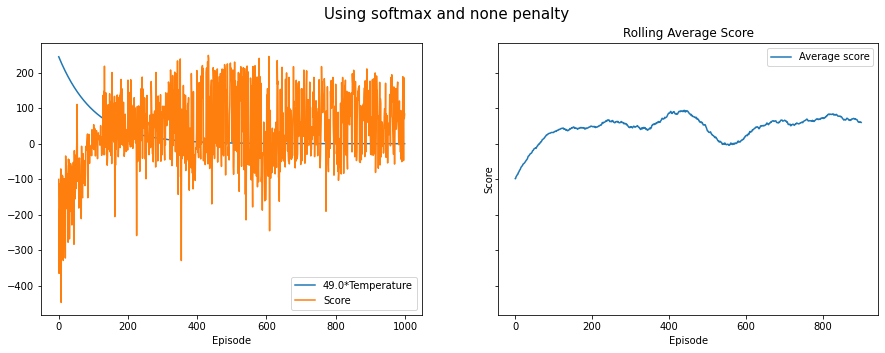

In [25]:
penalty = penalties[0]

results1, net1 = training(exploration_profile, penalty)

plot_results(results1, exploration_profile, penalty)

Updating target network...
EPISODE: 1 - FINAL SCORE: -131.9614614143909 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -106.82990332289619 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: -147.54610435792137 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: -177.1034973141125 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: -106.18761552194243 - Temperature: 4.810549903022062
Updating target network...
EPISODE: 6 - FINAL SCORE: -304.130266938044 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: -79.27802392967811 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: -84.26276564680538 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: -165.09727370550132 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: -84.79963365933816 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: -411.6970951681481 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: -95.8969731844544 - Temperature: 4.496120

EPISODE: 98 - FINAL SCORE: -25.829035657549014 - Temperature: 1.9596091643165272
EPISODE: 99 - FINAL SCORE: -39.3610637913667 - Temperature: 1.9407770224520895
EPISODE: 100 - FINAL SCORE: -3.393991009843404 - Temperature: 1.9221258603328273
Updating target network...
EPISODE: 101 - FINAL SCORE: 15.806199024389187 - Temperature: 1.903653938715887
EPISODE: 102 - FINAL SCORE: 58.426482155665695 - Temperature: 1.8853595350728032
EPISODE: 103 - FINAL SCORE: 25.92491892659166 - Temperature: 1.8672409434288693
EPISODE: 104 - FINAL SCORE: -8.912117434265681 - Temperature: 1.849296474204056
EPISODE: 105 - FINAL SCORE: 34.49391836236575 - Temperature: 1.8315244540554556
Updating target network...
EPISODE: 106 - FINAL SCORE: -6.026657433585342 - Temperature: 1.8139232257212385
EPISODE: 107 - FINAL SCORE: 14.65008924225188 - Temperature: 1.796491147866114
EPISODE: 108 - FINAL SCORE: 20.587950613438522 - Temperature: 1.7792265949282728
EPISODE: 109 - FINAL SCORE: -45.563453784993825 - Temperature: 

EPISODE: 194 - FINAL SCORE: 3.581927495436503 - Temperature: 0.7754659611059017
EPISODE: 195 - FINAL SCORE: 8.534440303407749 - Temperature: 0.7680136153746637
Updating target network...
EPISODE: 196 - FINAL SCORE: -68.3674855568618 - Temperature: 0.7606328878184114
EPISODE: 197 - FINAL SCORE: 14.104742018363382 - Temperature: 0.7533230901755995
EPISODE: 198 - FINAL SCORE: -19.17097249379883 - Temperature: 0.746083540798981
EPISODE: 199 - FINAL SCORE: 16.44745406839928 - Temperature: 0.7389135645920424
EPISODE: 200 - FINAL SCORE: -40.021041555782446 - Temperature: 0.7318124929460501
Updating target network...
EPISODE: 201 - FINAL SCORE: 5.859851237691089 - Temperature: 0.7247796636777022
EPISODE: 202 - FINAL SCORE: 125.3909214681544 - Temperature: 0.7178144209673791
EPISODE: 203 - FINAL SCORE: 24.86949913049895 - Temperature: 0.7109161152979872
EPISODE: 204 - FINAL SCORE: 7.554710444742753 - Temperature: 0.704084103394391
EPISODE: 205 - FINAL SCORE: 45.81349355602225 - Temperature: 0.6

EPISODE: 290 - FINAL SCORE: 176.4220425558212 - Temperature: 0.3068711188864223
Updating target network...
EPISODE: 291 - FINAL SCORE: 165.16146761483822 - Temperature: 0.30392204079972973
EPISODE: 292 - FINAL SCORE: 2.4943698727872743 - Temperature: 0.3010013038016119
EPISODE: 293 - FINAL SCORE: 167.93890385336516 - Temperature: 0.2981086355299008
EPISODE: 294 - FINAL SCORE: 246.5687175395007 - Temperature: 0.29524376623987014
EPISODE: 295 - FINAL SCORE: 115.58455705991817 - Temperature: 0.2924064287790814
Updating target network...
EPISODE: 296 - FINAL SCORE: 33.12611983859668 - Temperature: 0.28959635856247173
EPISODE: 297 - FINAL SCORE: 113.13988788466196 - Temperature: 0.28681329354768076
EPISODE: 298 - FINAL SCORE: 231.34343122115376 - Temperature: 0.28405697421061515
EPISODE: 299 - FINAL SCORE: 217.9398970516452 - Temperature: 0.28132714352124755
EPISODE: 300 - FINAL SCORE: -9.126628736405678 - Temperature: 0.2786235469196481
Updating target network...
EPISODE: 301 - FINAL SCORE

EPISODE: 385 - FINAL SCORE: 174.66274673658785 - Temperature: 0.12261486218661034
Updating target network...
EPISODE: 386 - FINAL SCORE: 111.48805298642971 - Temperature: 0.1214365147276199
EPISODE: 387 - FINAL SCORE: 87.59822263092695 - Temperature: 0.12026949136677996
EPISODE: 388 - FINAL SCORE: 173.83440052725825 - Temperature: 0.11911368327778638
EPISODE: 389 - FINAL SCORE: 161.53717469031392 - Temperature: 0.11796898268017236
EPISODE: 390 - FINAL SCORE: 234.16263397925678 - Temperature: 0.11683528282925784
Updating target network...
EPISODE: 391 - FINAL SCORE: 246.931267298591 - Temperature: 0.11571247800619522
EPISODE: 392 - FINAL SCORE: 192.95422551124335 - Temperature: 0.11460046350811118
EPISODE: 393 - FINAL SCORE: 159.50445428033933 - Temperature: 0.11349913563834291
EPISODE: 394 - FINAL SCORE: 192.65754344020758 - Temperature: 0.11240839169676829
EPISODE: 395 - FINAL SCORE: 256.7745119413265 - Temperature: 0.11132812997022898
Updating target network...
EPISODE: 396 - FINAL S

EPISODE: 479 - FINAL SCORE: 112.82586028785968 - Temperature: 0.04946796352604255
EPISODE: 480 - FINAL SCORE: -79.4972595694033 - Temperature: 0.04899256887907365
Updating target network...
EPISODE: 481 - FINAL SCORE: -51.86615257204541 - Temperature: 0.04852174284690629
EPISODE: 482 - FINAL SCORE: 0.15553414824702827 - Temperature: 0.04805544152445793
EPISODE: 483 - FINAL SCORE: 197.39822138072697 - Temperature: 0.04759362142858058
EPISODE: 484 - FINAL SCORE: 215.69774891624644 - Temperature: 0.047136239494005895
EPISODE: 485 - FINAL SCORE: 163.41635357665922 - Temperature: 0.0466832530693293
Updating target network...
EPISODE: 486 - FINAL SCORE: 48.87607243705753 - Temperature: 0.046234619913032696
EPISODE: 487 - FINAL SCORE: 189.24318826166365 - Temperature: 0.045790298189545414
EPISODE: 488 - FINAL SCORE: 208.6092784783316 - Temperature: 0.045350246465342955
EPISODE: 489 - FINAL SCORE: -95.10229438021189 - Temperature: 0.04491442370508329
EPISODE: 490 - FINAL SCORE: -58.19436233114

EPISODE: 573 - FINAL SCORE: 200.549657009474 - Temperature: 0.01995744538447232
EPISODE: 574 - FINAL SCORE: 11.170757215746942 - Temperature: 0.01976565130146024
EPISODE: 575 - FINAL SCORE: -0.5849788817850226 - Temperature: 0.019575700388732225
Updating target network...
EPISODE: 576 - FINAL SCORE: 130.8409088905042 - Temperature: 0.01938757493314174
EPISODE: 577 - FINAL SCORE: 155.51652168390024 - Temperature: 0.019201257391768284
EPISODE: 578 - FINAL SCORE: 146.36230132411774 - Temperature: 0.01901673039028149
EPISODE: 579 - FINAL SCORE: -21.420033766067025 - Temperature: 0.01883397672132095
EPISODE: 580 - FINAL SCORE: 182.8261245661356 - Temperature: 0.01865297934289159
Updating target network...
EPISODE: 581 - FINAL SCORE: 187.19206013884846 - Temperature: 0.018473721376774516
EPISODE: 582 - FINAL SCORE: 122.29448609622709 - Temperature: 0.018296186106953067
EPISODE: 583 - FINAL SCORE: 204.21171969966554 - Temperature: 0.018120356978054055
EPISODE: 584 - FINAL SCORE: 173.938022795

EPISODE: 667 - FINAL SCORE: 227.08657447698403 - Temperature: 0.008051668148103763
EPISODE: 668 - FINAL SCORE: 85.01757022715319 - Temperature: 0.007974290393614974
EPISODE: 669 - FINAL SCORE: -55.40402008019646 - Temperature: 0.007897656251105663
EPISODE: 670 - FINAL SCORE: -3.809123398826756 - Temperature: 0.007821758574351708
Updating target network...
EPISODE: 671 - FINAL SCORE: 241.40887910496087 - Temperature: 0.007746590285805277
EPISODE: 672 - FINAL SCORE: 233.00601760592747 - Temperature: 0.007672144375934854
EPISODE: 673 - FINAL SCORE: 104.266253939111 - Temperature: 0.007598413902571588
EPISODE: 674 - FINAL SCORE: 20.861524011886047 - Temperature: 0.007525391990261918
EPISODE: 675 - FINAL SCORE: 261.7756845167454 - Temperature: 0.007453071829626444
Updating target network...
EPISODE: 676 - FINAL SCORE: 256.82899335037416 - Temperature: 0.007381446676724935
EPISODE: 677 - FINAL SCORE: 263.42626207836054 - Temperature: 0.007310509852427447
EPISODE: 678 - FINAL SCORE: 22.301324

EPISODE: 760 - FINAL SCORE: 120.61426211704698 - Temperature: 0.003279900013332686
Updating target network...
EPISODE: 761 - FINAL SCORE: 188.92207253057245 - Temperature: 0.0032483796757689478
EPISODE: 762 - FINAL SCORE: 204.76751982061373 - Temperature: 0.0032171622534392383
EPISODE: 763 - FINAL SCORE: 189.6607047506081 - Temperature: 0.003186244835282127
EPISODE: 764 - FINAL SCORE: -74.14249115796406 - Temperature: 0.003155624538211923
EPISODE: 765 - FINAL SCORE: 3.07827090362142 - Temperature: 0.0031252985068498298
Updating target network...
EPISODE: 766 - FINAL SCORE: 224.55005031643526 - Temperature: 0.003095263913257674
EPISODE: 767 - FINAL SCORE: 200.4864758033418 - Temperature: 0.0030655179566741967
EPISODE: 768 - FINAL SCORE: -9.423992433644601 - Temperature: 0.0030360578632538816
EPISODE: 769 - FINAL SCORE: 123.77629392672654 - Temperature: 0.0030068808858082887
EPISODE: 770 - FINAL SCORE: 187.31145085571023 - Temperature: 0.0029779843035498783
Updating target network...
EPI

EPISODE: 853 - FINAL SCORE: 21.798034624441954 - Temperature: 0.001336088857560939
EPISODE: 854 - FINAL SCORE: 78.24848598835868 - Temperature: 0.0013232488405987512
EPISODE: 855 - FINAL SCORE: 219.18136157087548 - Temperature: 0.0013105322181508256
Updating target network...
EPISODE: 856 - FINAL SCORE: 153.61265422824295 - Temperature: 0.0012979378043771275
EPISODE: 857 - FINAL SCORE: 156.140121034287 - Temperature: 0.0012854644248337264
EPISODE: 858 - FINAL SCORE: 333.8987838013974 - Temperature: 0.0012731109163632759
EPISODE: 859 - FINAL SCORE: 194.4554520569621 - Temperature: 0.0012608761269865484
EPISODE: 860 - FINAL SCORE: 136.40768223607097 - Temperature: 0.0012487589157950119
Updating target network...
EPISODE: 861 - FINAL SCORE: 190.11058782825737 - Temperature: 0.0012367581528444388
EPISODE: 862 - FINAL SCORE: 39.13120405961742 - Temperature: 0.0012248727190495373
EPISODE: 863 - FINAL SCORE: 171.41734093431862 - Temperature: 0.0012131015060795947
EPISODE: 864 - FINAL SCORE: 1

Updating target network...
EPISODE: 946 - FINAL SCORE: -6.47197899745883 - Temperature: 0.0005442645897868794
EPISODE: 947 - FINAL SCORE: 163.86399678899284 - Temperature: 0.0005390341243689289
EPISODE: 948 - FINAL SCORE: 201.69123517892902 - Temperature: 0.0005338539245185014
EPISODE: 949 - FINAL SCORE: 100.10677198256028 - Temperature: 0.0005287235071758544
EPISODE: 950 - FINAL SCORE: 114.78219598853836 - Temperature: 0.0005236423939235231
Updating target network...
EPISODE: 951 - FINAL SCORE: 179.88614904025235 - Temperature: 0.0005186101109417065
EPISODE: 952 - FINAL SCORE: 13.754989223983264 - Temperature: 0.0005136261889640848
EPISODE: 953 - FINAL SCORE: 162.61620580125046 - Temperature: 0.0005086901632340582
EPISODE: 954 - FINAL SCORE: 19.976393971201247 - Temperature: 0.0005038015734614089
EPISODE: 955 - FINAL SCORE: 161.1260327638246 - Temperature: 0.0004989599637793775
Updating target network...
EPISODE: 956 - FINAL SCORE: 60.79553028615519 - Temperature: 0.000494164882702153

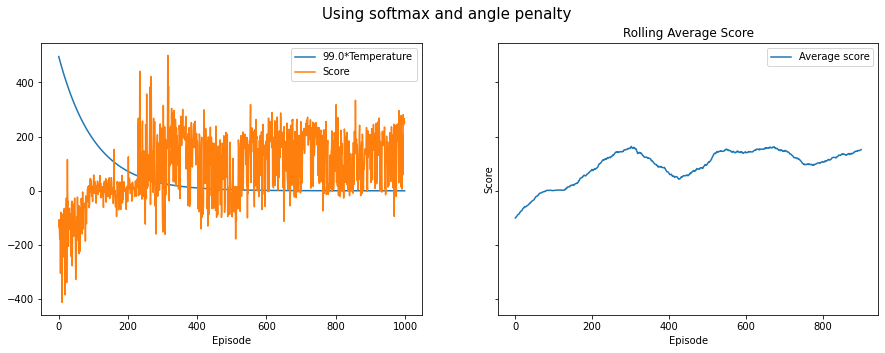

In [26]:
penalty = penalties[1]

results2, net2 = training(exploration_profile, penalty)

plot_results(results2, exploration_profile, penalty)

Updating target network...
EPISODE: 1 - FINAL SCORE: -161.75863368687163 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -212.18448164181237 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: -59.96650002969758 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: -153.9905146759384 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: -110.17384317903534 - Temperature: 4.810549903022062
Updating target network...
EPISODE: 6 - FINAL SCORE: -89.42461412279275 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: -184.66692183014953 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: -316.33708992357833 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: -198.41599940854167 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: -228.66681444775105 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: -99.15822915772127 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: -56.4128621275646 - Temperature: 4.49

EPISODE: 98 - FINAL SCORE: 19.14886281163072 - Temperature: 1.9596091643165272
EPISODE: 99 - FINAL SCORE: -20.192872307096394 - Temperature: 1.9407770224520895
EPISODE: 100 - FINAL SCORE: 14.471460211704809 - Temperature: 1.9221258603328273
Updating target network...
EPISODE: 101 - FINAL SCORE: 11.836857529967688 - Temperature: 1.903653938715887
EPISODE: 102 - FINAL SCORE: 9.643295159082683 - Temperature: 1.8853595350728032
EPISODE: 103 - FINAL SCORE: 12.728486595487041 - Temperature: 1.8672409434288693
EPISODE: 104 - FINAL SCORE: -32.187701504692384 - Temperature: 1.849296474204056
EPISODE: 105 - FINAL SCORE: 26.208079601887107 - Temperature: 1.8315244540554556
Updating target network...
EPISODE: 106 - FINAL SCORE: 9.391988650227518 - Temperature: 1.8139232257212385
EPISODE: 107 - FINAL SCORE: -15.3328007384536 - Temperature: 1.796491147866114
EPISODE: 108 - FINAL SCORE: 42.597687621192776 - Temperature: 1.7792265949282728
EPISODE: 109 - FINAL SCORE: 34.96479529676141 - Temperature: 1

EPISODE: 194 - FINAL SCORE: 223.14817256803485 - Temperature: 0.7754659611059017
EPISODE: 195 - FINAL SCORE: 247.4363722458024 - Temperature: 0.7680136153746637
Updating target network...
EPISODE: 196 - FINAL SCORE: 24.095453888733488 - Temperature: 0.7606328878184114
EPISODE: 197 - FINAL SCORE: -32.5220589253596 - Temperature: 0.7533230901755995
EPISODE: 198 - FINAL SCORE: 113.64549674533174 - Temperature: 0.746083540798981
EPISODE: 199 - FINAL SCORE: -27.700059892199448 - Temperature: 0.7389135645920424
EPISODE: 200 - FINAL SCORE: 96.36422971646186 - Temperature: 0.7318124929460501
Updating target network...
EPISODE: 201 - FINAL SCORE: -483.14750523928717 - Temperature: 0.7247796636777022
EPISODE: 202 - FINAL SCORE: 75.46498357314871 - Temperature: 0.7178144209673791
EPISODE: 203 - FINAL SCORE: 91.79615354269171 - Temperature: 0.7109161152979872
EPISODE: 204 - FINAL SCORE: 165.30338888363232 - Temperature: 0.704084103394391
EPISODE: 205 - FINAL SCORE: -4.802517602502931 - Temperature

EPISODE: 289 - FINAL SCORE: -6.880389647376219 - Temperature: 0.30984881306669776
EPISODE: 290 - FINAL SCORE: 16.505953531326753 - Temperature: 0.3068711188864223
Updating target network...
EPISODE: 291 - FINAL SCORE: 139.92800651540057 - Temperature: 0.30392204079972973
EPISODE: 292 - FINAL SCORE: 195.06155062027418 - Temperature: 0.3010013038016119
EPISODE: 293 - FINAL SCORE: 159.69029571577244 - Temperature: 0.2981086355299008
EPISODE: 294 - FINAL SCORE: -23.04325286709623 - Temperature: 0.29524376623987014
EPISODE: 295 - FINAL SCORE: -53.03508198483366 - Temperature: 0.2924064287790814
Updating target network...
EPISODE: 296 - FINAL SCORE: 101.50684258543053 - Temperature: 0.28959635856247173
EPISODE: 297 - FINAL SCORE: 129.86172839822407 - Temperature: 0.28681329354768076
EPISODE: 298 - FINAL SCORE: 196.2047522120304 - Temperature: 0.28405697421061515
EPISODE: 299 - FINAL SCORE: -14.298693790228057 - Temperature: 0.28132714352124755
EPISODE: 300 - FINAL SCORE: 160.96436551087982 -

EPISODE: 384 - FINAL SCORE: 100.01496732114545 - Temperature: 0.12380464362604086
EPISODE: 385 - FINAL SCORE: 196.7506271518577 - Temperature: 0.12261486218661034
Updating target network...
EPISODE: 386 - FINAL SCORE: 138.46578787043936 - Temperature: 0.1214365147276199
EPISODE: 387 - FINAL SCORE: 227.19317759652097 - Temperature: 0.12026949136677996
EPISODE: 388 - FINAL SCORE: 316.59150310437894 - Temperature: 0.11911368327778638
EPISODE: 389 - FINAL SCORE: 305.9619565590752 - Temperature: 0.11796898268017236
EPISODE: 390 - FINAL SCORE: 186.18678023844507 - Temperature: 0.11683528282925784
Updating target network...
EPISODE: 391 - FINAL SCORE: 199.01088830413363 - Temperature: 0.11571247800619522
EPISODE: 392 - FINAL SCORE: -110.79822080807845 - Temperature: 0.11460046350811118
EPISODE: 393 - FINAL SCORE: 256.05452142171345 - Temperature: 0.11349913563834291
EPISODE: 394 - FINAL SCORE: 214.4282476538485 - Temperature: 0.11240839169676829
EPISODE: 395 - FINAL SCORE: 187.7571082727821 -

EPISODE: 478 - FINAL SCORE: -125.31067248644672 - Temperature: 0.04994797111892421
EPISODE: 479 - FINAL SCORE: -36.611533205604374 - Temperature: 0.04946796352604255
EPISODE: 480 - FINAL SCORE: 206.9054729157217 - Temperature: 0.04899256887907365
Updating target network...
EPISODE: 481 - FINAL SCORE: 138.0295729023216 - Temperature: 0.04852174284690629
EPISODE: 482 - FINAL SCORE: 178.77671350817957 - Temperature: 0.04805544152445793
EPISODE: 483 - FINAL SCORE: 228.13171680884415 - Temperature: 0.04759362142858058
EPISODE: 484 - FINAL SCORE: -86.59594737484157 - Temperature: 0.047136239494005895
EPISODE: 485 - FINAL SCORE: 228.28509075705045 - Temperature: 0.0466832530693293
Updating target network...
EPISODE: 486 - FINAL SCORE: -57.9813377081829 - Temperature: 0.046234619913032696
EPISODE: 487 - FINAL SCORE: 195.41558694992563 - Temperature: 0.045790298189545414
EPISODE: 488 - FINAL SCORE: 176.0286039442697 - Temperature: 0.045350246465342955
EPISODE: 489 - FINAL SCORE: 161.33396648541

EPISODE: 572 - FINAL SCORE: -147.87999720061555 - Temperature: 0.02015110052279279
EPISODE: 573 - FINAL SCORE: -92.85080987235312 - Temperature: 0.01995744538447232
EPISODE: 574 - FINAL SCORE: 27.904490932334795 - Temperature: 0.01976565130146024
EPISODE: 575 - FINAL SCORE: -185.023967996178 - Temperature: 0.019575700388732225
Updating target network...
EPISODE: 576 - FINAL SCORE: 228.83949678190754 - Temperature: 0.01938757493314174
EPISODE: 577 - FINAL SCORE: 193.0583811732234 - Temperature: 0.019201257391768284
EPISODE: 578 - FINAL SCORE: 191.40174988700585 - Temperature: 0.01901673039028149
EPISODE: 579 - FINAL SCORE: -151.10337800498957 - Temperature: 0.01883397672132095
EPISODE: 580 - FINAL SCORE: 156.786705423531 - Temperature: 0.01865297934289159
Updating target network...
EPISODE: 581 - FINAL SCORE: 192.6186934304473 - Temperature: 0.018473721376774516
EPISODE: 582 - FINAL SCORE: -124.50038722469206 - Temperature: 0.018296186106953067
EPISODE: 583 - FINAL SCORE: 218.3784255640

Updating target network...
EPISODE: 666 - FINAL SCORE: 12.732454554671598 - Temperature: 0.008129796730138854
EPISODE: 667 - FINAL SCORE: 84.75774080192 - Temperature: 0.008051668148103763
EPISODE: 668 - FINAL SCORE: -20.862651932519114 - Temperature: 0.007974290393614974
EPISODE: 669 - FINAL SCORE: 16.79933113633626 - Temperature: 0.007897656251105663
EPISODE: 670 - FINAL SCORE: 50.435747374491505 - Temperature: 0.007821758574351708
Updating target network...
EPISODE: 671 - FINAL SCORE: 93.7172611051707 - Temperature: 0.007746590285805277
EPISODE: 672 - FINAL SCORE: 62.8412363995754 - Temperature: 0.007672144375934854
EPISODE: 673 - FINAL SCORE: 75.25414465195874 - Temperature: 0.007598413902571588
EPISODE: 674 - FINAL SCORE: -6.323859024581266 - Temperature: 0.007525391990261918
EPISODE: 675 - FINAL SCORE: 108.39178857916465 - Temperature: 0.007453071829626444
Updating target network...
EPISODE: 676 - FINAL SCORE: 54.535667100232466 - Temperature: 0.007381446676724935
EPISODE: 677 - 

EPISODE: 759 - FINAL SCORE: 79.49829957726276 - Temperature: 0.0033117262054390894
EPISODE: 760 - FINAL SCORE: -1.4291846532747297 - Temperature: 0.003279900013332686
Updating target network...
EPISODE: 761 - FINAL SCORE: 214.65571938280502 - Temperature: 0.0032483796757689478
EPISODE: 762 - FINAL SCORE: 133.2767904756799 - Temperature: 0.0032171622534392383
EPISODE: 763 - FINAL SCORE: 80.57650188039077 - Temperature: 0.003186244835282127
EPISODE: 764 - FINAL SCORE: 112.70270437700839 - Temperature: 0.003155624538211923
EPISODE: 765 - FINAL SCORE: 83.02654392190182 - Temperature: 0.0031252985068498298
Updating target network...
EPISODE: 766 - FINAL SCORE: 127.76696992410973 - Temperature: 0.003095263913257674
EPISODE: 767 - FINAL SCORE: 99.49068542277041 - Temperature: 0.0030655179566741967
EPISODE: 768 - FINAL SCORE: 72.87602393584957 - Temperature: 0.0030360578632538816
EPISODE: 769 - FINAL SCORE: 57.991348753191126 - Temperature: 0.0030068808858082887
EPISODE: 770 - FINAL SCORE: 153

EPISODE: 852 - FINAL SCORE: 198.85318818390908 - Temperature: 0.001349053466384106
EPISODE: 853 - FINAL SCORE: 235.65505982303648 - Temperature: 0.001336088857560939
EPISODE: 854 - FINAL SCORE: 185.28124147825633 - Temperature: 0.0013232488405987512
EPISODE: 855 - FINAL SCORE: 185.21374597197877 - Temperature: 0.0013105322181508256
Updating target network...
EPISODE: 856 - FINAL SCORE: 195.5821069678915 - Temperature: 0.0012979378043771275
EPISODE: 857 - FINAL SCORE: 195.18472137883626 - Temperature: 0.0012854644248337264
EPISODE: 858 - FINAL SCORE: 225.82695753862933 - Temperature: 0.0012731109163632759
EPISODE: 859 - FINAL SCORE: 200.77379844140614 - Temperature: 0.0012608761269865484
EPISODE: 860 - FINAL SCORE: 150.13354676193248 - Temperature: 0.0012487589157950119
Updating target network...
EPISODE: 861 - FINAL SCORE: 141.8740577222259 - Temperature: 0.0012367581528444388
EPISODE: 862 - FINAL SCORE: 192.07484276472155 - Temperature: 0.0012248727190495373
EPISODE: 863 - FINAL SCORE

EPISODE: 945 - FINAL SCORE: 15.892190124215565 - Temperature: 0.0005495458085194191
Updating target network...
EPISODE: 946 - FINAL SCORE: 271.1432846278875 - Temperature: 0.0005442645897868794
EPISODE: 947 - FINAL SCORE: 292.48943704155226 - Temperature: 0.0005390341243689289
EPISODE: 948 - FINAL SCORE: 188.11051717374863 - Temperature: 0.0005338539245185014
EPISODE: 949 - FINAL SCORE: 210.18286747008358 - Temperature: 0.0005287235071758544
EPISODE: 950 - FINAL SCORE: 235.45067069615442 - Temperature: 0.0005236423939235231
Updating target network...
EPISODE: 951 - FINAL SCORE: 31.89416610151676 - Temperature: 0.0005186101109417065
EPISODE: 952 - FINAL SCORE: 231.90874227346401 - Temperature: 0.0005136261889640848
EPISODE: 953 - FINAL SCORE: 248.95008337051203 - Temperature: 0.0005086901632340582
EPISODE: 954 - FINAL SCORE: 214.69277745628142 - Temperature: 0.0005038015734614089
EPISODE: 955 - FINAL SCORE: 29.423422435022687 - Temperature: 0.0004989599637793775
Updating target network.

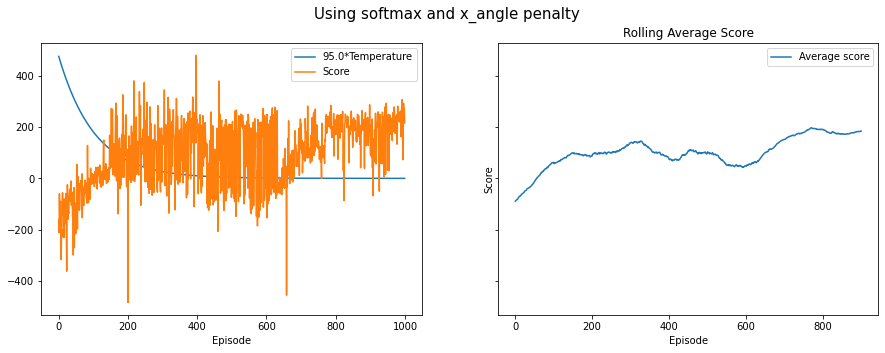

In [27]:
penalty = penalties[2]

results3, net3 = training(exploration_profile, penalty)

plot_results(results3, exploration_profile, penalty)

Updating target network...
EPISODE: 1 - FINAL SCORE: -340.84750037510133 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -110.7819745946737 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: -154.65379041728994 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: -84.79711641158111 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: -99.38989233830449 - Temperature: 4.810549903022062
Updating target network...
EPISODE: 6 - FINAL SCORE: -108.85094516191423 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: -100.34286791665305 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: -85.48920170839942 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: -108.83494027601895 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: -115.75932910084722 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: -138.5092887311543 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: -113.08787398038797 - Temperature: 4.4

EPISODE: 98 - FINAL SCORE: 17.32714111329811 - Temperature: 1.9596091643165272
EPISODE: 99 - FINAL SCORE: -8.928624218251898 - Temperature: 1.9407770224520895
EPISODE: 100 - FINAL SCORE: 28.806925819939664 - Temperature: 1.9221258603328273
Updating target network...
EPISODE: 101 - FINAL SCORE: 1.6623710710425286 - Temperature: 1.903653938715887
EPISODE: 102 - FINAL SCORE: -20.93045360024513 - Temperature: 1.8853595350728032
EPISODE: 103 - FINAL SCORE: -4.417958004439001 - Temperature: 1.8672409434288693
EPISODE: 104 - FINAL SCORE: -30.145225668523153 - Temperature: 1.849296474204056
EPISODE: 105 - FINAL SCORE: 6.641571425685029 - Temperature: 1.8315244540554556
Updating target network...
EPISODE: 106 - FINAL SCORE: -10.96095361480154 - Temperature: 1.8139232257212385
EPISODE: 107 - FINAL SCORE: -6.973290381793717 - Temperature: 1.796491147866114
EPISODE: 108 - FINAL SCORE: 11.19601753684232 - Temperature: 1.7792265949282728
EPISODE: 109 - FINAL SCORE: -24.184713241364676 - Temperature:

EPISODE: 194 - FINAL SCORE: -20.16598257412751 - Temperature: 0.7754659611059017
EPISODE: 195 - FINAL SCORE: -22.67258370843284 - Temperature: 0.7680136153746637
Updating target network...
EPISODE: 196 - FINAL SCORE: -22.38995497806016 - Temperature: 0.7606328878184114
EPISODE: 197 - FINAL SCORE: 20.24868064646138 - Temperature: 0.7533230901755995
EPISODE: 198 - FINAL SCORE: 7.866267023597459 - Temperature: 0.746083540798981
EPISODE: 199 - FINAL SCORE: 0.11219696093094456 - Temperature: 0.7389135645920424
EPISODE: 200 - FINAL SCORE: -14.355682631033787 - Temperature: 0.7318124929460501
Updating target network...
EPISODE: 201 - FINAL SCORE: -2.647256159707098 - Temperature: 0.7247796636777022
EPISODE: 202 - FINAL SCORE: -29.679239363639468 - Temperature: 0.7178144209673791
EPISODE: 203 - FINAL SCORE: 9.249083242672413 - Temperature: 0.7109161152979872
EPISODE: 204 - FINAL SCORE: -7.1877562668418165 - Temperature: 0.704084103394391
EPISODE: 205 - FINAL SCORE: 25.9669224569124 - Temperatu

EPISODE: 289 - FINAL SCORE: -40.11777216212414 - Temperature: 0.30984881306669776
EPISODE: 290 - FINAL SCORE: 24.57377245445437 - Temperature: 0.3068711188864223
Updating target network...
EPISODE: 291 - FINAL SCORE: 201.54717901128242 - Temperature: 0.30392204079972973
EPISODE: 292 - FINAL SCORE: 37.594593418619425 - Temperature: 0.3010013038016119
EPISODE: 293 - FINAL SCORE: -14.456182458243987 - Temperature: 0.2981086355299008
EPISODE: 294 - FINAL SCORE: 219.70306011271072 - Temperature: 0.29524376623987014
EPISODE: 295 - FINAL SCORE: 202.0422606627675 - Temperature: 0.2924064287790814
Updating target network...
EPISODE: 296 - FINAL SCORE: 165.7063063671439 - Temperature: 0.28959635856247173
EPISODE: 297 - FINAL SCORE: 28.454342071060097 - Temperature: 0.28681329354768076
EPISODE: 298 - FINAL SCORE: 25.97285094551252 - Temperature: 0.28405697421061515
EPISODE: 299 - FINAL SCORE: 49.23064949785493 - Temperature: 0.28132714352124755
EPISODE: 300 - FINAL SCORE: 272.04285142209625 - Tem

EPISODE: 384 - FINAL SCORE: 182.39911816528377 - Temperature: 0.12380464362604086
EPISODE: 385 - FINAL SCORE: 173.37837328991645 - Temperature: 0.12261486218661034
Updating target network...
EPISODE: 386 - FINAL SCORE: 152.87587173852796 - Temperature: 0.1214365147276199
EPISODE: 387 - FINAL SCORE: 133.30512799846844 - Temperature: 0.12026949136677996
EPISODE: 388 - FINAL SCORE: 214.3414328556853 - Temperature: 0.11911368327778638
EPISODE: 389 - FINAL SCORE: 74.50756021307625 - Temperature: 0.11796898268017236
EPISODE: 390 - FINAL SCORE: -14.234240162276492 - Temperature: 0.11683528282925784
Updating target network...
EPISODE: 391 - FINAL SCORE: 218.90357058993052 - Temperature: 0.11571247800619522
EPISODE: 392 - FINAL SCORE: 73.77685450975687 - Temperature: 0.11460046350811118
EPISODE: 393 - FINAL SCORE: 140.0053694697756 - Temperature: 0.11349913563834291
EPISODE: 394 - FINAL SCORE: -84.00189938459955 - Temperature: 0.11240839169676829
EPISODE: 395 - FINAL SCORE: 271.84383000692253 -

EPISODE: 478 - FINAL SCORE: -25.1305525381734 - Temperature: 0.04994797111892421
EPISODE: 479 - FINAL SCORE: -26.977392023828948 - Temperature: 0.04946796352604255
EPISODE: 480 - FINAL SCORE: 125.07027337007194 - Temperature: 0.04899256887907365
Updating target network...
EPISODE: 481 - FINAL SCORE: 140.96863424532347 - Temperature: 0.04852174284690629
EPISODE: 482 - FINAL SCORE: 131.71716868404522 - Temperature: 0.04805544152445793
EPISODE: 483 - FINAL SCORE: 288.1847841839054 - Temperature: 0.04759362142858058
EPISODE: 484 - FINAL SCORE: -126.27556603519048 - Temperature: 0.047136239494005895
EPISODE: 485 - FINAL SCORE: 1.331920581921433 - Temperature: 0.0466832530693293
Updating target network...
EPISODE: 486 - FINAL SCORE: -115.54449325579633 - Temperature: 0.046234619913032696
EPISODE: 487 - FINAL SCORE: -119.70096358702358 - Temperature: 0.045790298189545414
EPISODE: 488 - FINAL SCORE: 109.80541319820493 - Temperature: 0.045350246465342955
EPISODE: 489 - FINAL SCORE: 43.510640267

EPISODE: 572 - FINAL SCORE: -148.08791870074947 - Temperature: 0.02015110052279279
EPISODE: 573 - FINAL SCORE: 195.86915539571964 - Temperature: 0.01995744538447232
EPISODE: 574 - FINAL SCORE: -105.40653186672859 - Temperature: 0.01976565130146024
EPISODE: 575 - FINAL SCORE: -108.80429660759364 - Temperature: 0.019575700388732225
Updating target network...
EPISODE: 576 - FINAL SCORE: 215.90477178811204 - Temperature: 0.01938757493314174
EPISODE: 577 - FINAL SCORE: -58.31270165432378 - Temperature: 0.019201257391768284
EPISODE: 578 - FINAL SCORE: 136.71194255339873 - Temperature: 0.01901673039028149
EPISODE: 579 - FINAL SCORE: 207.01246264380137 - Temperature: 0.01883397672132095
EPISODE: 580 - FINAL SCORE: 125.24936900173489 - Temperature: 0.01865297934289159
Updating target network...
EPISODE: 581 - FINAL SCORE: -59.747499300406886 - Temperature: 0.018473721376774516
EPISODE: 582 - FINAL SCORE: 29.569072780015425 - Temperature: 0.018296186106953067
EPISODE: 583 - FINAL SCORE: -93.8359

EPISODE: 665 - FINAL SCORE: -134.25752400741936 - Temperature: 0.008208683425302619
Updating target network...
EPISODE: 666 - FINAL SCORE: -47.8587897030764 - Temperature: 0.008129796730138854
EPISODE: 667 - FINAL SCORE: 73.62797187320687 - Temperature: 0.008051668148103763
EPISODE: 668 - FINAL SCORE: -173.05106381864363 - Temperature: 0.007974290393614974
EPISODE: 669 - FINAL SCORE: 109.80217764273014 - Temperature: 0.007897656251105663
EPISODE: 670 - FINAL SCORE: -200.46393965324285 - Temperature: 0.007821758574351708
Updating target network...
EPISODE: 671 - FINAL SCORE: -112.02106515462974 - Temperature: 0.007746590285805277
EPISODE: 672 - FINAL SCORE: -83.69443843747285 - Temperature: 0.007672144375934854
EPISODE: 673 - FINAL SCORE: -141.4997237041151 - Temperature: 0.007598413902571588
EPISODE: 674 - FINAL SCORE: -87.00005553245518 - Temperature: 0.007525391990261918
EPISODE: 675 - FINAL SCORE: -109.42181481990582 - Temperature: 0.007453071829626444
Updating target network...
EPI

EPISODE: 757 - FINAL SCORE: -155.0106434588563 - Temperature: 0.003376308053397664
EPISODE: 758 - FINAL SCORE: -151.04476489979345 - Temperature: 0.003343861219918088
EPISODE: 759 - FINAL SCORE: -150.5516415238878 - Temperature: 0.0033117262054390894
EPISODE: 760 - FINAL SCORE: -130.3019411051472 - Temperature: 0.003279900013332686
Updating target network...
EPISODE: 761 - FINAL SCORE: -105.71832895639888 - Temperature: 0.0032483796757689478
EPISODE: 762 - FINAL SCORE: -147.11135961323993 - Temperature: 0.0032171622534392383
EPISODE: 763 - FINAL SCORE: -172.1180164048908 - Temperature: 0.003186244835282127
EPISODE: 764 - FINAL SCORE: -115.43353276933927 - Temperature: 0.003155624538211923
EPISODE: 765 - FINAL SCORE: -134.0036443194871 - Temperature: 0.0031252985068498298
Updating target network...
EPISODE: 766 - FINAL SCORE: 32.71617963464716 - Temperature: 0.003095263913257674
EPISODE: 767 - FINAL SCORE: 176.82729418995126 - Temperature: 0.0030655179566741967
EPISODE: 768 - FINAL SCOR

EPISODE: 849 - FINAL SCORE: -96.42248869368096 - Temperature: 0.0013887069924392503
EPISODE: 850 - FINAL SCORE: -121.38620717637923 - Temperature: 0.0013753613072046771
Updating target network...
EPISODE: 851 - FINAL SCORE: -44.240650392480674 - Temperature: 0.0013621438760333085
EPISODE: 852 - FINAL SCORE: -32.436249087738084 - Temperature: 0.001349053466384106
EPISODE: 853 - FINAL SCORE: -223.04700567213283 - Temperature: 0.001336088857560939
EPISODE: 854 - FINAL SCORE: -95.56774063087768 - Temperature: 0.0013232488405987512
EPISODE: 855 - FINAL SCORE: -43.201164895725334 - Temperature: 0.0013105322181508256
Updating target network...
EPISODE: 856 - FINAL SCORE: -213.9858936858443 - Temperature: 0.0012979378043771275
EPISODE: 857 - FINAL SCORE: -100.67233868077493 - Temperature: 0.0012854644248337264
EPISODE: 858 - FINAL SCORE: -181.88509099994172 - Temperature: 0.0012731109163632759
EPISODE: 859 - FINAL SCORE: -1.5420688976498207 - Temperature: 0.0012608761269865484
EPISODE: 860 - F

Updating target network...
EPISODE: 941 - FINAL SCORE: -61.264451613289815 - Temperature: 0.0005711881381525488
EPISODE: 942 - FINAL SCORE: -69.97617082511336 - Temperature: 0.000565698933343321
EPISODE: 943 - FINAL SCORE: -87.82080708698857 - Temperature: 0.0005602624806264864
EPISODE: 944 - FINAL SCORE: -3.173548011657659 - Temperature: 0.0005548782730464203
EPISODE: 945 - FINAL SCORE: -126.11038022236558 - Temperature: 0.0005495458085194191
Updating target network...
EPISODE: 946 - FINAL SCORE: -36.70925141003026 - Temperature: 0.0005442645897868794
EPISODE: 947 - FINAL SCORE: -71.86517921442032 - Temperature: 0.0005390341243689289
EPISODE: 948 - FINAL SCORE: -10.83978465257482 - Temperature: 0.0005338539245185014
EPISODE: 949 - FINAL SCORE: -28.116549718244006 - Temperature: 0.0005287235071758544
EPISODE: 950 - FINAL SCORE: -73.7691170159199 - Temperature: 0.0005236423939235231
Updating target network...
EPISODE: 951 - FINAL SCORE: -42.60922401092397 - Temperature: 0.00051861011094

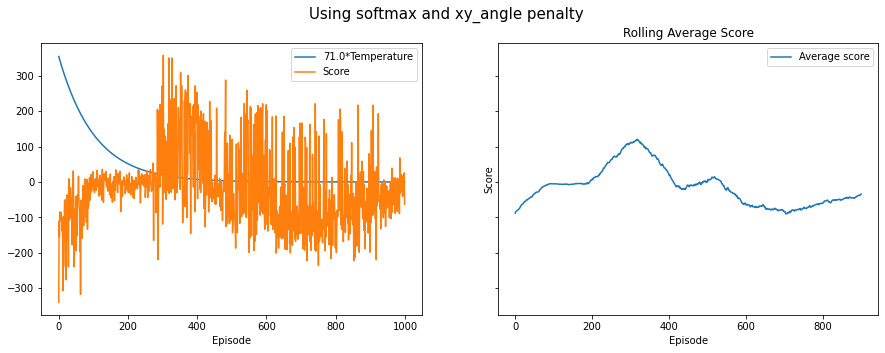

In [28]:
penalty = penalties[3]

results4, net4 = training(exploration_profile, penalty)

plot_results(results4, exploration_profile, penalty)

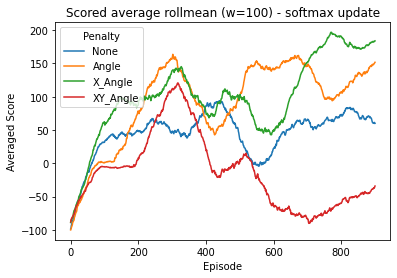

In [29]:
plt.plot(moving_average(results1, 100), label = "None")
plt.plot(moving_average(results2, 100), label = "Angle")
plt.plot(moving_average(results3, 100), label = "X_Angle")
plt.plot(moving_average(results4, 100), label = "XY_Angle")
plt.legend(title = "Penalty")
plt.ylabel("Averaged Score")
plt.xlabel("Episode")
plt.title("Scored average rollmean (w=100) - softmax update")
plt.savefig('Results_Moonlander.png')
plt.show()

# Final test

In [31]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2')
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, "MoonLander_test_final" ,video_callable=lambda episode_id: True) # Save a video every episode
scores = []
# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(net3, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score§
    scores.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

print("Max score obtained is \t \t:", max(scores))

EPISODE 1 - FINAL SCORE: 197.8981438180594
EPISODE 2 - FINAL SCORE: 216.06124582785023
EPISODE 3 - FINAL SCORE: 183.3876619222451
EPISODE 4 - FINAL SCORE: -25.92901834389426
EPISODE 5 - FINAL SCORE: 124.10496971724034
EPISODE 6 - FINAL SCORE: 232.00934111757456
EPISODE 7 - FINAL SCORE: 236.13691357881467
EPISODE 8 - FINAL SCORE: 205.70894454317724
EPISODE 9 - FINAL SCORE: -24.060898804377825
EPISODE 10 - FINAL SCORE: 130.58268513551423
Max score obtained is 	 	: 236.13691357881467


In [32]:
print("Average score obtained is:", np.mean(scores))

Average score obtained is: 147.58999885122034
